In [1]:
import torch
import torch.nn.functional as F
import umap.umap_ as umap
import os
import numpy as np
import pandas as pd
import sklearn
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy
import pickle

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random
def setup_seed(seed: int = 42, deterministic: bool = False):

    random.seed(seed)
    
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False  

seed = 42
setup_seed(seed=seed)



In [ ]:
expr=pd.read_csv('Data/2.2/expr.csv').iloc[:,1:]
meta=pd.read_csv("Data/2.2/stateFate_inVitro_metadata.csv")
scaler = StandardScaler()
scaler.fit(expr)
xs = pd.DataFrame(scaler.transform(expr), index = expr.index, columns = expr.columns)
pca = sklearn.decomposition.PCA(n_components = 50)
xp = pd.DataFrame(pca.fit_transform(xs))
um = umap.UMAP(n_components = 2, metric = 'euclidean', n_neighbors = 50)
data_day2=torch.from_numpy(xp[meta['Time point']==2].values)
data_day4=torch.from_numpy(xp[meta['Time point']==4].values)
data_day6=torch.from_numpy(xp[meta['Time point']==6].values)
x_seq=torch.cat([data_day2,data_day4,data_day6])
xu = um.fit_transform(x_seq)
data={'expr':expr,
      'meta':meta,
      'scaler':scaler,
      'xs':xs,
      'pca':pca,
      'xp':xp,
      'um':um,
      'xu':xu}
# torch.save(data,'weinreb.pt')

In [4]:
from scope import computations as cmp
from scope import clustering as cl
from scope import visualizations as vi

data_lst = [data_day2,data_day4,data_day6]
time_steps = [2,4,6]

cluster_centers, labels_list, best_k = cl.kmeans_auto([d.cuda() for d in data_lst],tol=1e-4,method='calinski_harabasz',max_k=8)
print(best_k)

max_variance_differences = cmp.max_adjacent_covariance_diagonal_differences(data_lst)
print(max_variance_differences)

# scal = cmp.eps_scalar()
eps_func = cmp.piecewise_eps_function(time_steps, max_variance_differences,snr=0.95,min_eps=0.1) 

[2, 2, 5]
[32.03110940378178, 31.236443712464926]


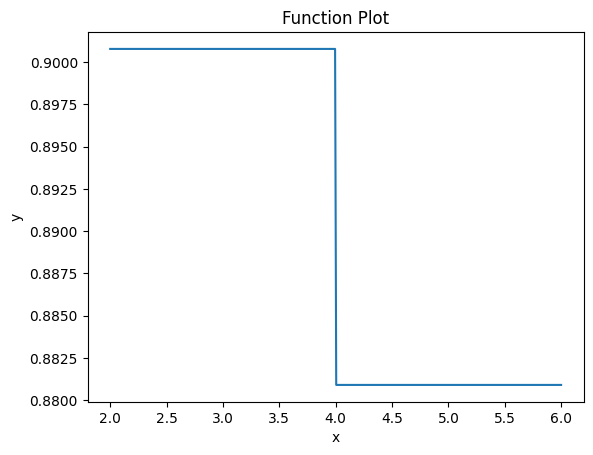

In [5]:
# 生成输入数据
x = np.linspace(time_steps[0], time_steps[-1], 400)

# 计算输出数据
y = [eps_func(x_i) for x_i in x]

# 绘制图像
plt.plot(x, y)

# 添加标题和标签
plt.title('Function Plot')
plt.xlabel('x')
plt.ylabel('y')

# 显示图像
plt.show()

In [6]:
import scope
from scope import model
steps = 128
eps = eps_func

eps_test = eps_func
sb_object=model.sb_muti_model(data_lst,time_steps,N_pretraining=40,N_finetuning=40,backbone_lr=1e-3,finetuning_lr=1e-3,
                              steps=steps,eps=eps,early_stop=True,patience=8,B=128,lambda_=1e-3,save=True,record_gap=1,save_path='model_history/weinreb_no_prematch',
                              prematched=False)

processed: 40: 100%|██████████| 40/40 [07:51<00:00, 11.78s/it, loss=1140.711575828642, loss_fore=1131.7596523107268, loss_back=1149.6634993465557] 


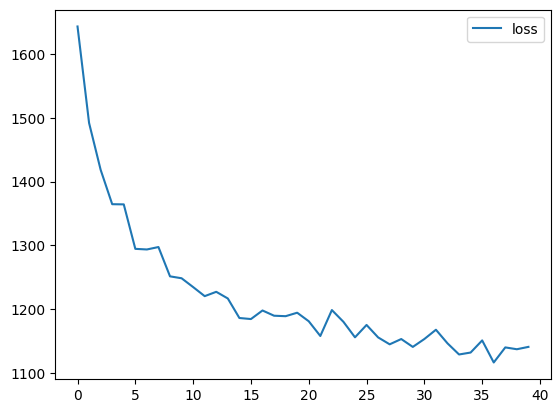

In [7]:
sb_object.backbone_train()

In [8]:
fore_base=sb_object.eval_fore(data_day2.cuda().double(),sb_object.v_fore)

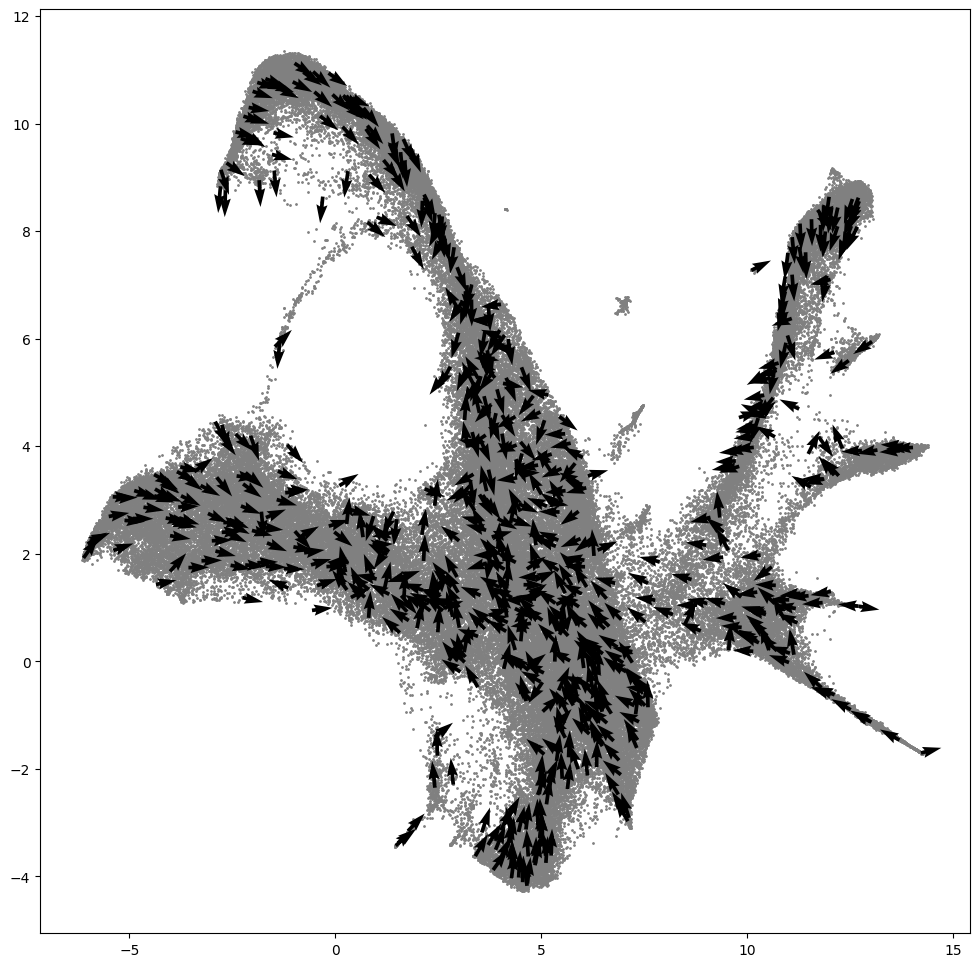

In [9]:
vi.visualize_drift_func([d.cuda() for d in data_lst],xp,sb_object,meta['Time point'].values,umap_model=um,save_path='./weinreb_results_no_prematch/drift_backbone')

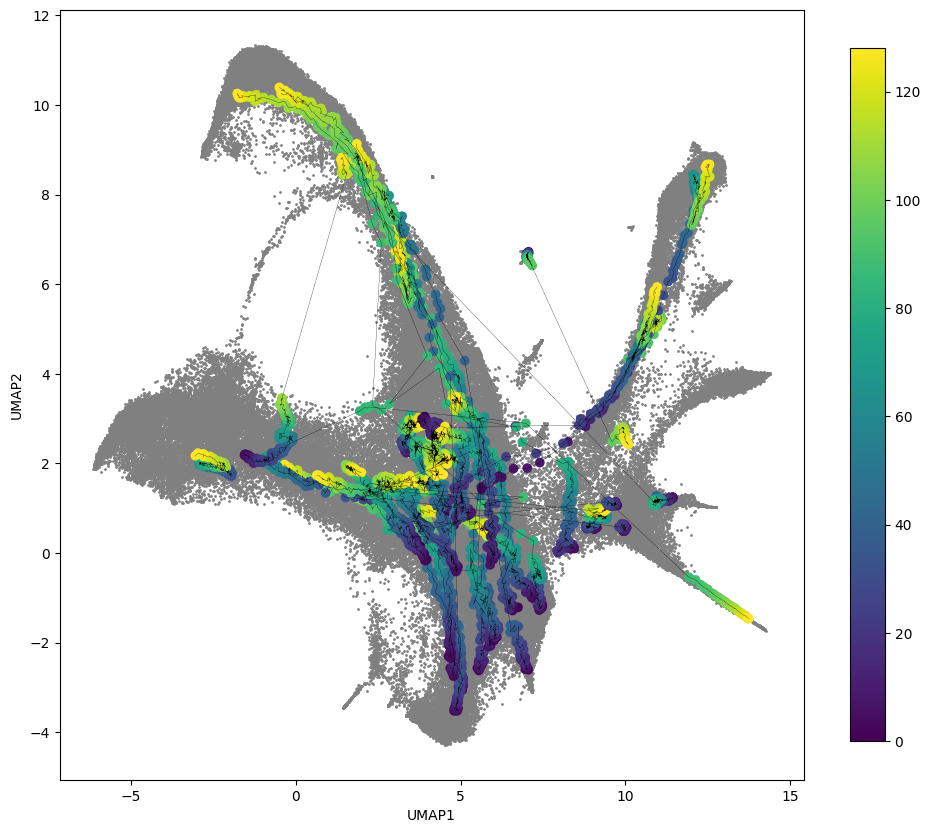

In [10]:
vi.visualize_generated_trajectories(data_lst,fore_base,umap_model=um,save_path='./weinreb_results_no_prematch/generated_trajectories_backbone')

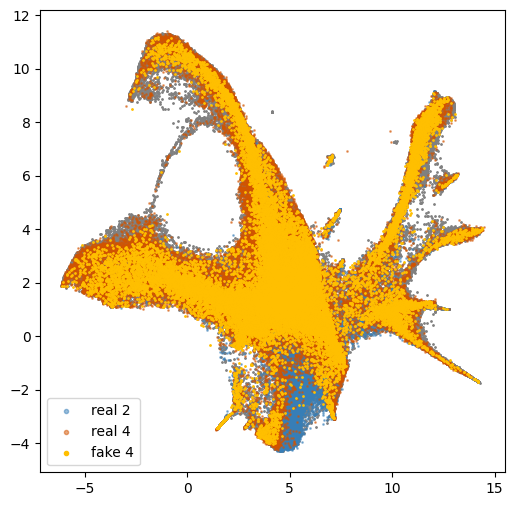

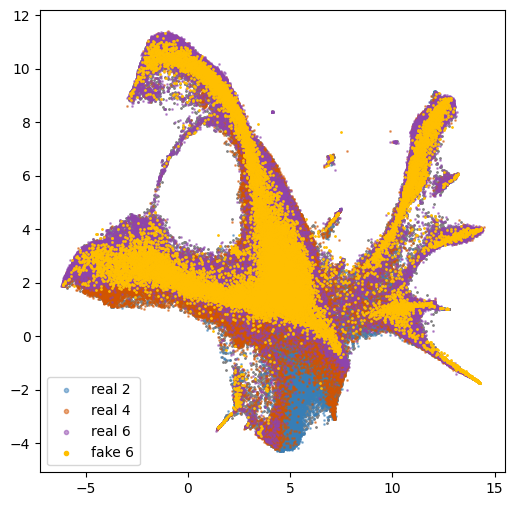

In [11]:
vi.visualize_generated_populations(data_lst,fore_base,time_steps,umap_model=um,save_path='./weinreb_results_no_prematch/generated_populations_backbone')

processed: 40: 100%|██████████| 40/40 [1:55:09<00:00, 172.74s/it, loss=532.8845554143966, loss_back=532.8845554143966]  


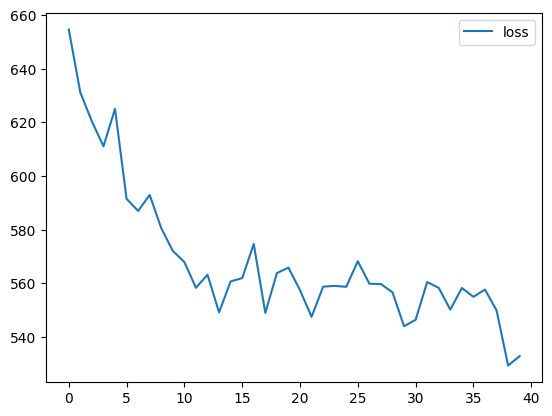

In [12]:
sb_object.fine_tune(change=4)

In [13]:
fore_ft=sb_object.eval_fore(data_day2.cuda().double(),sb_object.v_fore_fine_tuned)

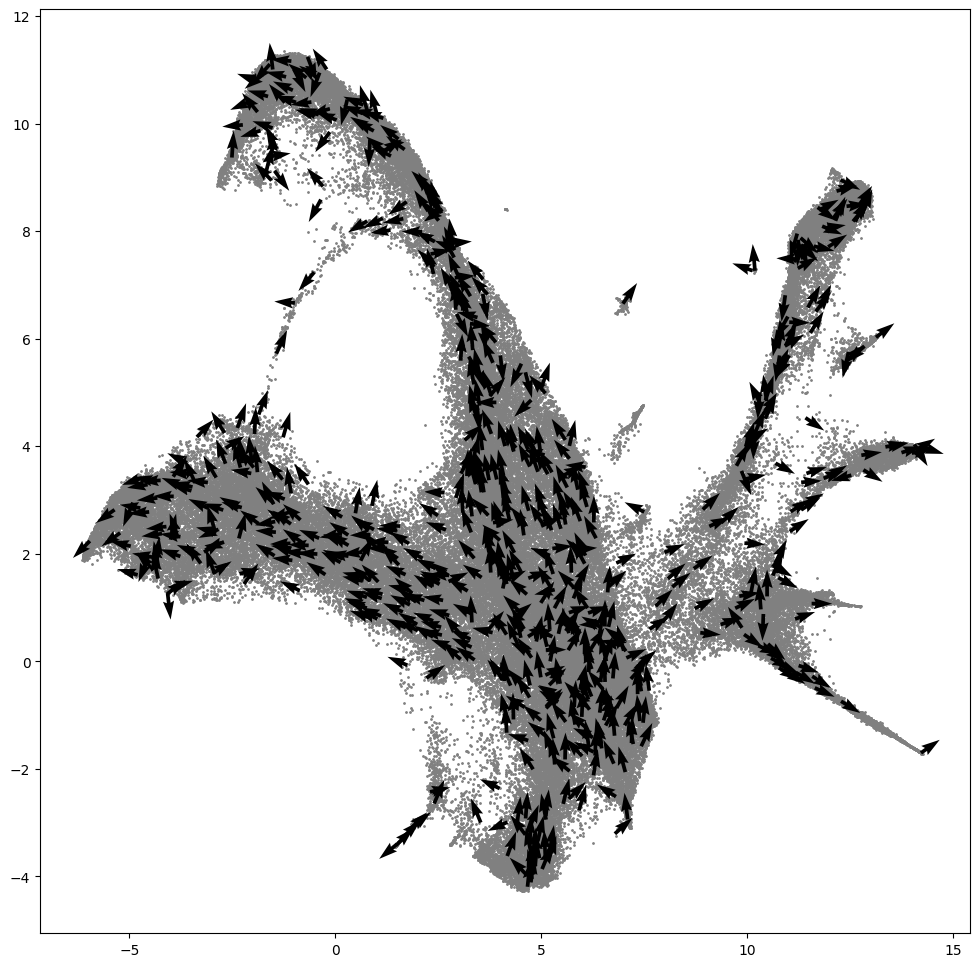

In [14]:
vi.visualize_drift_func(data_lst,xp,sb_object,meta['Time point'].values,umap_model=um,save_path='./weinreb_results_no_prematch/drift_fine_tuned',fine_tuned=True)

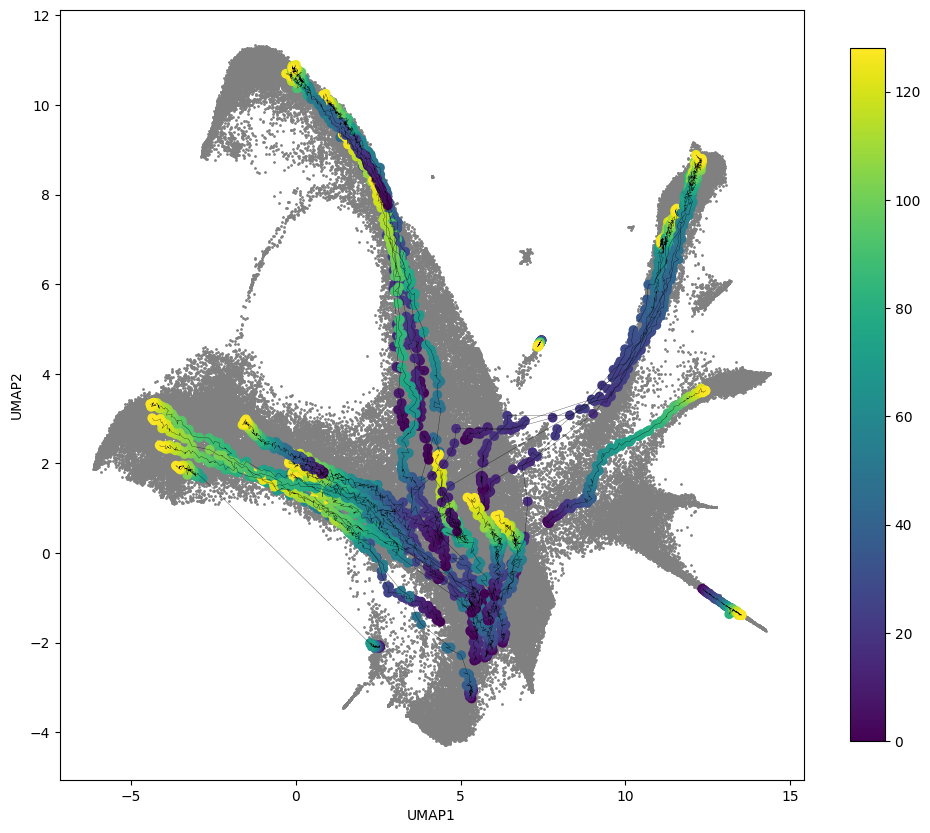

In [15]:
vi.visualize_generated_trajectories(data_lst,fore_ft,umap_model=um,save_path='./weinreb_results_no_prematch/generated_trajectories_fine_tuned')

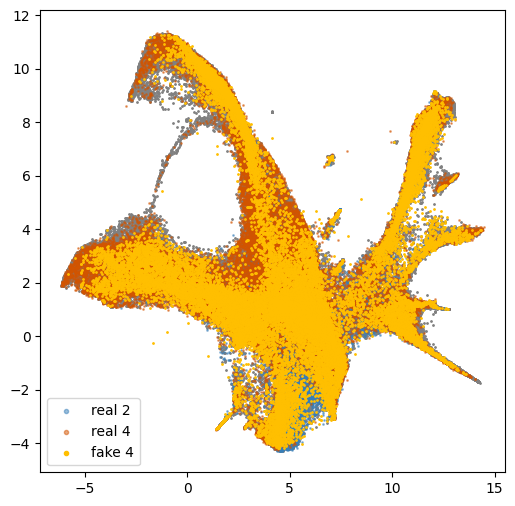

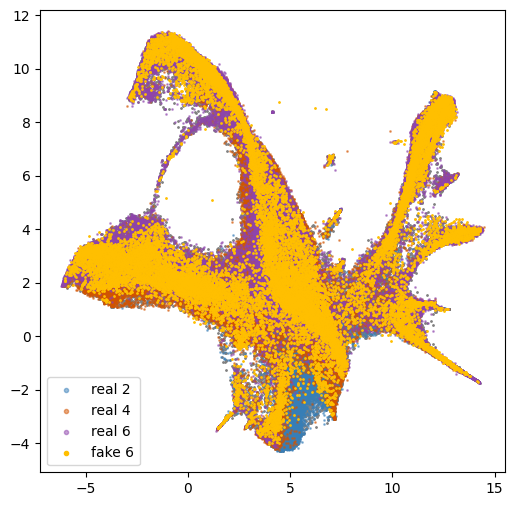

In [16]:
vi.visualize_generated_populations(data_lst,fore_ft,time_steps,umap_model=um,save_path='./weinreb_results_no_prematch/generated_populations_fine_tuned')

In [30]:
from geomloss import SamplesLoss
ot_solver = SamplesLoss("sinkhorn", p = 2, blur = 0.1, scaling = 0.7,backend='auto')
# 转换为 PyTorch 张量
tensor1 = torch.tensor(data_day4, dtype=torch.float32).contiguous().cuda()
tensor2 = torch.tensor(data_day6, dtype=torch.float32).contiguous().cuda()
tensor3 = torch.tensor(fore_base[len(fore_base)//2], dtype=torch.float32).contiguous().cuda()
tensor4 = torch.tensor(fore_base[-1], dtype=torch.float32).contiguous().cuda()
tensor5 = torch.tensor(fore_ft[len(fore_base)//2], dtype=torch.float32).contiguous().cuda()
tensor6 = torch.tensor(fore_ft[-1], dtype=torch.float32).contiguous().cuda()
print("backbone real4-fake4",ot_solver(tensor1[np.random.choice(data_day4.shape[0],10000),:], tensor3).item())
print("backbone real6-fake6",ot_solver(tensor2[np.random.choice(data_day6.shape[0],10000),:], tensor4).item())
print("finetuned real4-fake4",ot_solver(tensor1[np.random.choice(data_day4.shape[0],10000),:], tensor5).item())
print("finetuned real6-fake6",ot_solver(tensor2[np.random.choice(data_day6.shape[0],10000),:], tensor6).item())

/tmp/ipykernel_26774/3166991390.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor1 = torch.tensor(data_day4, dtype=torch.float32).contiguous().cuda()
/tmp/ipykernel_26774/3166991390.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor2 = torch.tensor(data_day6, dtype=torch.float32).contiguous().cuda()
/tmp/ipykernel_26774/3166991390.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor3 = torch.tensor(fore_base[len(fore_base)//2], dtype=torch.float32).contiguous().cuda()
/tmp/ipykernel_26774/3166991390.py:7: UserWarnin

backbone real4-fake4 36.438720703125
backbone real6-fake6 68.8396224975586
finetuned real4-fake4 40.99574661254883
finetuned real6-fake6 45.37715148925781


/tmp/ipykernel_26774/634742954.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  box.set_xticklabels(["unperturbed","2.5","5","10","-2.5","-5","-10"])


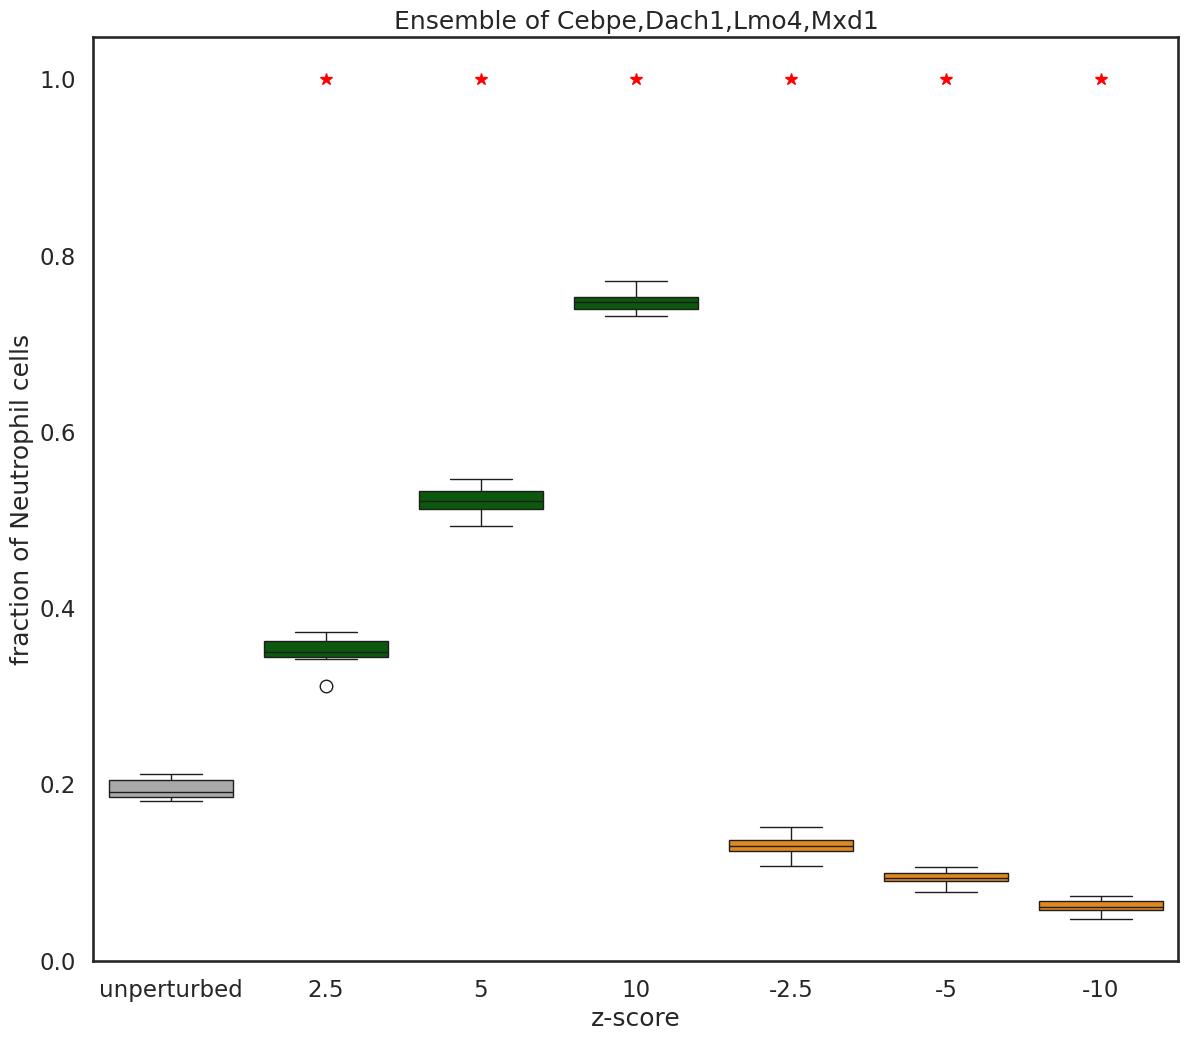

/tmp/ipykernel_26774/634742954.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  box.set_xticklabels(["unperturbed","2.5","5","10","-2.5","-5","-10"])


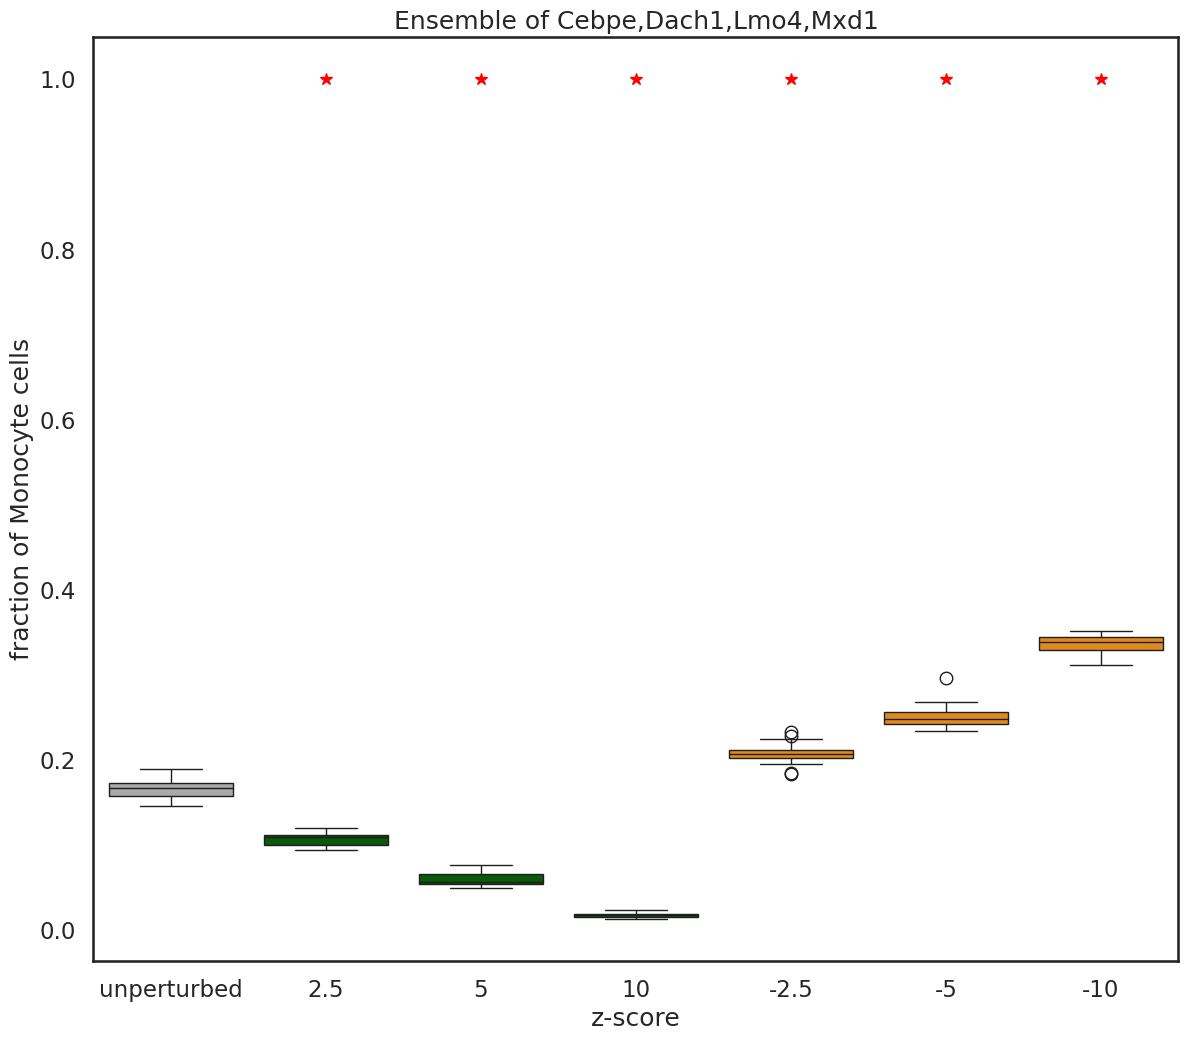

In [32]:
from sklearn.neighbors import KNeighborsClassifier
xp_day6=xp[meta['Time point']==6].values
y_day6=meta[meta['Time point']==6]['Cell type annotation']
knn=KNeighborsClassifier(n_neighbors=10)
knn.fit(xp_day6,y_day6)
def predict_fate(sim,knn):
    yp=[]
    for i in range(sim.shape[0]):
        yp.append(knn.predict(sim[i,:,:]))
    df=pd.DataFrame(yp)
    #score=((df.eq('Neutrophil')).sum(axis=1)+1)/((df.eq('Neutrophil')).sum(axis=1)+(df.eq('Monocyte')).sum(axis=1)+2)
    score1=((df.eq('Neutrophil')).sum(axis=1)+1)/1000
    score2=((df.eq('Monocyte')).sum(axis=1)+1)/1000
    return score1.values, score2.values   


disturb_name=['Cebpe','Dach1','Lmo4','Mxd1']
disturb_values=[0,2.5,5,10,-2.5,-5,-10]
box_result1=[]
box_result2=[]
for i in disturb_values:
    xs_disturbed=xs.copy()
    if i!=0:
        xs_disturbed.loc[:,disturb_name]=i
    xp_disturbed = pd.DataFrame(pca.transform(xs_disturbed))
    data_choose=torch.from_numpy(xp_disturbed[(meta['Time point']==2) & (meta['Cell type annotation']=='Undifferentiated')].values)
    sim_result=[]
    for n in range(20):
        data_chosed=data_choose[torch.randperm(data_choose.size(0))[:1000],:]
        sim_result.append(sb_object.eval_fore(data_chosed,sb_object.v_fore_fine_tuned)[-1])
    sim_result=torch.stack(sim_result)
    temp1,temp2 = predict_fate(sim_result,knn)
    box_result1.append(temp1)
    box_result2.append(temp2)
    
    
fig, ax = plt.subplots(figsize=(14,12), sharex=True, sharey=True)#len(filenames)/3, figsize=(10,20))
sns.set_context("talk")
sns.set_style("white")
#mypal=["lightgrey","sandybrown","sienna","brown"]
mypal=["darkgrey", "darkgreen", "darkgreen", "darkgreen", "darkorange", "darkorange","darkorange"]
#mypal=["lightgrey","white", "lightgray", "darkgray"]
ax.set_title("Ensemble of Cebpe,Dach1,Lmo4,Mxd1")
#ax.set_ylim(0.4,0.7)
for j in range(1, 7):
    #stat, p = scipy.stats.mannwhitneyu(neu_dist_all[i][0], neu_dist_all[i][j], alternative="greater")
    stat, p = scipy.stats.ttest_ind(box_result1[0], box_result1[j], equal_var=False)
    x1, x2 = 0,j
    if p < .05:
        y=1
        ax.plot(x2, y, "*", c="r")
box=sns.boxplot(data=np.array(box_result1).T, ax=ax, palette=mypal)
box.set_xticklabels(["unperturbed","2.5","5","10","-2.5","-5","-10"])
box.set_ylabel("fraction of Neutrophil cells")
ax.set_xlabel("z-score")
plt.savefig(
            'Ncell.svg', 
            format='svg',
            dpi=1200,                
            bbox_inches='tight',    
            pad_inches=0.1          
        )
plt.show()
plt.close()


fig, ax = plt.subplots(figsize=(14,12), sharex=True, sharey=True)#len(filenames)/3, figsize=(10,20))
sns.set_context("talk")
sns.set_style("white")
#mypal=["lightgrey","sandybrown","sienna","brown"]
mypal=["darkgrey", "darkgreen", "darkgreen", "darkgreen", "darkorange", "darkorange","darkorange"]
#mypal=["lightgrey","white", "lightgray", "darkgray"]
ax.set_title("Ensemble of Cebpe,Dach1,Lmo4,Mxd1")
#ax.set_ylim(0.4,0.7)
for j in range(1, 7):
    #stat, p = scipy.stats.mannwhitneyu(neu_dist_all[i][0], neu_dist_all[i][j], alternative="greater")
    stat, p = scipy.stats.ttest_ind(box_result2[0], box_result2[j], equal_var=False)
    x1, x2 = 0,j
    if p < .05:
        y=1
        ax.plot(x2, y, "*", c="r")
box=sns.boxplot(data=np.array(box_result2).T, ax=ax, palette=mypal)
box.set_xticklabels(["unperturbed","2.5","5","10","-2.5","-5","-10"])
box.set_ylabel("fraction of Monocyte cells")
ax.set_xlabel("z-score")
plt.savefig(
            'Mcell.svg', 
            format='svg',
            dpi=1200,                
            bbox_inches='tight',    
            pad_inches=0.1          
        )
plt.show()

/tmp/ipykernel_26774/1082394798.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  box.set_xticklabels(["unperturbed","2.5","5","10","-2.5","-5","-10"])


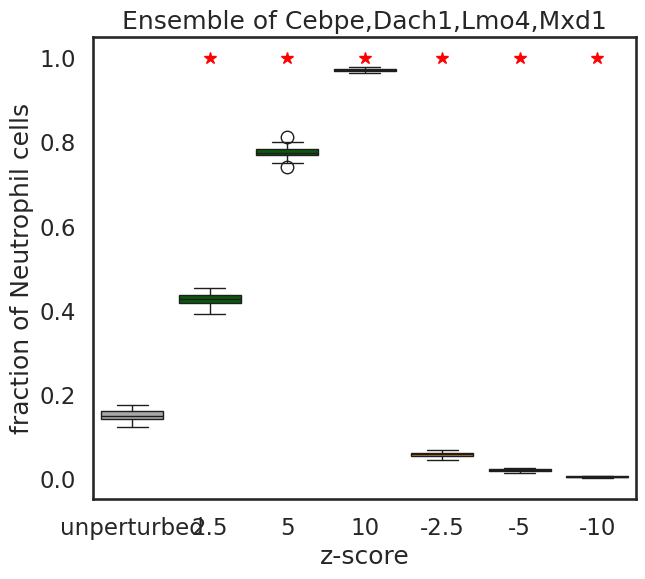

/tmp/ipykernel_26774/1082394798.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  box.set_xticklabels(["unperturbed","2.5","5","10","-2.5","-5","-10"])


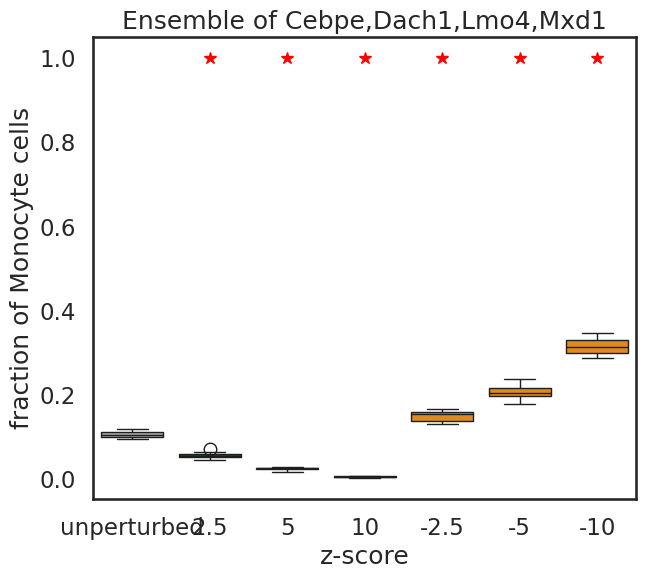

In [19]:
from sklearn.neighbors import KNeighborsClassifier
xp_day6=xp[meta['Time point']==6].values
y_day6=meta[meta['Time point']==6]['Cell type annotation']
knn=KNeighborsClassifier(n_neighbors=10)
knn.fit(xp_day6,y_day6)
def predict_fate(sim,knn):
    yp=[]
    for i in range(sim.shape[0]):
        yp.append(knn.predict(sim[i,:,:]))
    df=pd.DataFrame(yp)
    #score=((df.eq('Neutrophil')).sum(axis=1)+1)/((df.eq('Neutrophil')).sum(axis=1)+(df.eq('Monocyte')).sum(axis=1)+2)
    score1=((df.eq('Neutrophil')).sum(axis=1)+1)/1000
    score2=((df.eq('Monocyte')).sum(axis=1)+1)/1000
    return score1.values, score2.values   


disturb_name=['Cebpe','Dach1','Lmo4','Mxd1']
disturb_values=[0,2.5,5,10,-2.5,-5,-10]
box_result1=[]
box_result2=[]
for i in disturb_values:
    xs_disturbed=xs.copy()
    if i!=0:
        xs_disturbed.loc[:,disturb_name]=i
    xp_disturbed = pd.DataFrame(pca.transform(xs_disturbed))
    data_choose=torch.from_numpy(xp_disturbed[(meta['Time point']==2) & (meta['Cell type annotation']=='Undifferentiated')].values)
    sim_result=[]
    for n in range(20):
        data_chosed=data_choose[torch.randperm(data_choose.size(0))[:1000],:]
        sim_result.append(sb_object.eval_fore(data_chosed,sb_object.v_fore)[-1])
    sim_result=torch.stack(sim_result)
    temp1,temp2 = predict_fate(sim_result,knn)
    box_result1.append(temp1)
    box_result2.append(temp2)
    
    
fig, ax = plt.subplots(figsize=(7,6), sharex=True, sharey=True)#len(filenames)/3, figsize=(10,20))
sns.set_context("talk")
sns.set_style("white")
#mypal=["lightgrey","sandybrown","sienna","brown"]
mypal=["darkgrey", "darkgreen", "darkgreen", "darkgreen", "darkorange", "darkorange","darkorange"]
#mypal=["lightgrey","white", "lightgray", "darkgray"]
ax.set_title("Ensemble of Cebpe,Dach1,Lmo4,Mxd1")
#ax.set_ylim(0.4,0.7)
for j in range(1, 7):
    #stat, p = scipy.stats.mannwhitneyu(neu_dist_all[i][0], neu_dist_all[i][j], alternative="greater")
    stat, p = scipy.stats.ttest_ind(box_result1[0], box_result1[j], equal_var=False)
    x1, x2 = 0,j
    if p < .05:
        y=1
        ax.plot(x2, y, "*", c="r")
box=sns.boxplot(data=np.array(box_result1).T, ax=ax, palette=mypal)
box.set_xticklabels(["unperturbed","2.5","5","10","-2.5","-5","-10"])
box.set_ylabel("fraction of Neutrophil cells")
ax.set_xlabel("z-score")
plt.show()


fig, ax = plt.subplots(figsize=(7,6), sharex=True, sharey=True)#len(filenames)/3, figsize=(10,20))
sns.set_context("talk")
sns.set_style("white")
#mypal=["lightgrey","sandybrown","sienna","brown"]
mypal=["darkgrey", "darkgreen", "darkgreen", "darkgreen", "darkorange", "darkorange","darkorange"]
#mypal=["lightgrey","white", "lightgray", "darkgray"]
ax.set_title("Ensemble of Cebpe,Dach1,Lmo4,Mxd1")
#ax.set_ylim(0.4,0.7)
for j in range(1, 7):
    #stat, p = scipy.stats.mannwhitneyu(neu_dist_all[i][0], neu_dist_all[i][j], alternative="greater")
    stat, p = scipy.stats.ttest_ind(box_result2[0], box_result2[j], equal_var=False)
    x1, x2 = 0,j
    if p < .05:
        y=1
        ax.plot(x2, y, "*", c="r")
box=sns.boxplot(data=np.array(box_result2).T, ax=ax, palette=mypal)
box.set_xticklabels(["unperturbed","2.5","5","10","-2.5","-5","-10"])
box.set_ylabel("fraction of Monocyte cells")
ax.set_xlabel("z-score")
plt.show()

clone ws-loss

In [ ]:
timepoints=meta["Time point"]
import scipy.io as sio
clone= sio.mmread("Data/2.2/stateFate_inVitro_clone_matrix.mtx.gz")
dense_clone= clone.todense()
dense_clone.shape

(130887, 5864)

In [21]:
df_dense_clone=pd.DataFrame(dense_clone)
num_clone=df_dense_clone.sum(axis=0).sort_values(ascending=False)
num_clone.head(20)

1261    177
2370    165
5714    142
292     134
5209    130
3345    124
1843    117
2256    112
5150    108
2673    107
4256    105
2539     99
4758     97
1325     95
3612     95
3165     93
3438     93
5789     92
3869     90
3250     90
dtype: int64

In [22]:

day2_clones = df_dense_clone[timepoints == 2]
day2_clones = day2_clones.sum(axis=0)>0
meta_ = meta.copy()
np_clone = df_dense_clone.to_numpy()
meta_['clone'] = np.asarray(np.argmax(np_clone, axis = 1))[:]
meta_.loc[np.asarray(np_clone.sum(axis = 1) == 0), 'clone'] = -1
nc = meta_.loc[meta_['clone'] != -1]
nc = nc.groupby(['clone'])['Time point'].value_counts().unstack().fillna(0).astype(int)
nc.head(20)

Time point,2,4,6
clone,,,
0,0,2,3
1,0,13,7
2,1,14,5
3,0,2,0
4,0,3,6
5,1,0,5
6,1,0,1
7,0,1,1
8,0,3,3


In [23]:
cloneindex=nc.loc[(nc.iloc[:,0]>0)&(nc.iloc[:,1]>0)&(nc.iloc[:,2]>0)&(nc.iloc[:,0]+nc.iloc[:,2]+nc.iloc[:,2]>5),:].index

In [24]:
day2_index=[]
clone_index = cloneindex
for i, clone_id in enumerate(clone_index):
    index1 = df_dense_clone.loc[df_dense_clone.loc[:, clone_id] == 1, clone_id].index
    px = meta["id"].isin(index1)
    pxx= (meta["id"].isin(index1)) &(meta["Time point"] == 2)
    list=meta.loc[pxx,:].index
    day2_index.append(list)
day4_index=[]
clone_index = cloneindex
for i, clone_id in enumerate(clone_index):
    index1 = df_dense_clone.loc[df_dense_clone.loc[:, clone_id] == 1, clone_id].index
    px = meta["id"].isin(index1)
    pxx= (meta["id"].isin(index1)) &(meta["Time point"] == 4)
    list=meta.loc[pxx,:].index
    day4_index.append(list)
day6_index=[]
clone_index = cloneindex
for i, clone_id in enumerate(clone_index):
    index1 = df_dense_clone.loc[df_dense_clone.loc[:, clone_id] == 1, clone_id].index
    px = meta["id"].isin(index1)
    pxx= (meta["id"].isin(index1)) &(meta["Time point"] == 6)
    list=meta.loc[pxx,:].index
    day6_index.append(list)

In [25]:
px

0         False
1         False
2         False
3         False
4         False
          ...  
130882    False
130883    False
130884    False
130885    False
130886    False
Name: id, Length: 130887, dtype: bool

In [26]:
all_xps = []
all_xps_backbone = []
device = torch.device('cuda:0')

for i in range(len(day2_index)):
    px = day2_index[i]
    x_i = torch.from_numpy(xp.values[px]).to(device)  # (m, feature_dim)
    n = len(day6_index[i]) 

    sample_indices = torch.randint(0, len(x_i), (n,), device=x_i.device)
    repeated_xi = x_i[sample_indices]
    all_xps.append(np.stack(sb_object.eval_fore(repeated_xi, sb_object.v_fore_fine_tuned)))
    all_xps_backbone.append(np.stack(sb_object.eval_fore(repeated_xi, sb_object.v_fore)))

In [27]:
all_xpsday4 = []  
all_xpsday4_backbone = []  
for i in range(len(day2_index)):
    px = day2_index[i]
    x_i = torch.from_numpy(xp.values[px]).to(device)  # (m, feature_dim)
    n = len(day4_index[i])  

    sample_indices = torch.randint(0, len(x_i), (n,), device=x_i.device)
    repeated_xi = x_i[sample_indices]
    all_xpsday4.append(np.stack(
        cmp.generate_one_stage(sb_object.t_lists_stage,
                                   repeated_xi.double().cuda(),
                                   sb_object.v_fore_fine_tuned,
                                   sb_object.scale_m_fore,
                                   sb_object.delta_t,
                                   sb_object.eps,
                                   1)
    ))
    all_xpsday4_backbone.append(np.stack(
        cmp.generate_one_stage(sb_object.t_lists_stage,
                                   repeated_xi.double().cuda(),
                                   sb_object.v_fore,
                                   sb_object.scale_m_fore,
                                   sb_object.delta_t,
                                   sb_object.eps,
                                   1)
    ))

In [28]:
xps_day6_ref= []  
for i in range(len(day2_index)):
    px = day6_index[i]
    x_i = torch.from_numpy(xp.values[px]).to(device)  
    xps_day6_ref.append(x_i) 

xps_day4_ref= []  
for i in range(len(day2_index)):
    px = day4_index[i]
    x_i = torch.from_numpy(xp.values[px]).to(device)  
    xps_day4_ref.append(x_i) 

xps_day2_ref= [] 
for i in range(len(day2_index)):
    px = day2_index[i]
    x_i = torch.from_numpy(xp.values[px]).to(device)  
    xps_day2_ref.append(x_i) 

In [29]:
from geomloss import SamplesLoss
ot_solver = SamplesLoss("sinkhorn", p = 2, blur = 0.1, scaling = 0.7)
ot_results_day6 = []
ot_results_day6_backbone = []
for i in range(len(xps_day6_ref)):
    array1 = xps_day6_ref[i]
    tensor1 = torch.tensor(array1, dtype=torch.float32).to(device)
    array2 = all_xps[i][-1,:,:]
    tensor2 = torch.tensor(array2, dtype=torch.float32).to(device)
    ot_distance=ot_solver(tensor1, tensor2)
    ot_results_day6.append(ot_distance.item())
    array3 = all_xps_backbone[i][-1,:,:]
    ot_distance=ot_solver(tensor1, tensor3)
    ot_results_day6_backbone.append(ot_distance.item())

/tmp/ipykernel_26774/682994412.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor1 = torch.tensor(array1, dtype=torch.float32).to(device)


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.97 GiB. GPU 0 has a total capacity of 15.60 GiB of which 1.46 GiB is free. Process 24021 has 274.00 MiB memory in use. Process 57325 has 294.00 MiB memory in use. Process 66763 has 9.67 GiB memory in use. Process 38206 has 438.00 MiB memory in use. Process 66082 has 218.00 MiB memory in use. Process 25805 has 3.24 GiB memory in use. Of the allocated memory 3.02 GiB is allocated by PyTorch, and 13.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
ot_results_day4 = []
ot_results_day4_backbone = []
for i in range(len(xps_day4_ref)):
    array1 = xps_day4_ref[i]
    tensor1 = torch.tensor(array1, dtype=torch.float32).to(device)
    array2 = all_xpsday4[i][-1,:,:]
    tensor2 = torch.tensor(array2, dtype=torch.float32).to(device)
    ot_distance=ot_solver(tensor1, tensor2)
    ot_results_day4.append(ot_distance.item())
    array3 = all_xpsday4_backbone[i][-1,:,:]
    tensor3 = torch.tensor(array3, dtype=torch.float32).to(device)
    ot_distance=ot_solver(tensor1, tensor3)
    ot_results_day4_backbone.append(ot_distance.item())

In [ ]:

# day4_distance_filtered = [x for x in day4_distance if x <= 1000]
# day6_distance_filtered = [x for x in day6_distance if x <= 1000]


plt.figure(figsize=(8, 6))
plt.boxplot([ot_results_day4, ot_results_day4_backbone, ot_results_day6, ot_results_day6_backbone], 
            vert=False, 
            patch_artist=True,showfliers=False)


plt.title('Box Plot of Day 4 and Day 6 Distance (Filtered)', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.yticks([1, 2, 3, 4], ['Day 4','Day 4 Backbone', 'Day 6','Day 6 Backbone'])  # 设置每个箱型图的标签
plt.grid(alpha=0.3)
plt.show()
#plt.savefig("/mnt/weinreb2025.3.26/result/figure/clone_lossbox.svg", dpi=500)

In [ ]:
xps_clone_ref_combined = []

for x2, x4, x6 in zip(xps_day2_ref, xps_day4_ref, xps_day6_ref):
    combined = torch.cat([x2, x4, x6], dim=0)
    xps_clone_ref_combined.append(combined)
xps_clone_sim_combined = []
xps_clone_sim_combined_backbone = []
for x2, x4, x4_backbone, x6, x6_backbone in zip(xps_day2_ref, all_xpsday4, all_xpsday4_backbone, all_xps, all_xps_backbone):
    if isinstance(x4, np.ndarray):
        x4 = torch.from_numpy(x4).to(x2.device)
    if isinstance(x6, np.ndarray):
        x6 = torch.from_numpy(x6).to(x2.device)
    if isinstance(x4_backbone, np.ndarray):
        x4_backbone = torch.from_numpy(x4_backbone).to(x2.device)
    if isinstance(x6_backbone, np.ndarray):
        x6_backbone = torch.from_numpy(x6_backbone).to(x2.device)
    combined = torch.cat([x2, x4[-1,:,:], x6[-1,:,:]], dim=0)
    xps_clone_sim_combined.append(combined)
    combined = torch.cat([x2, x4_backbone[-1,:,:], x6_backbone[-1,:,:]], dim=0)
    xps_clone_sim_combined_backbone.append(combined)

In [ ]:
ot_solver = SamplesLoss("sinkhorn", p = 2, blur = 0.1, 
                    scaling = 0.7)
ot_results_full_clone = []
ot_results_full_clone_backbone = []
for i in range(len(xps_clone_sim_combined)):
    array1 = xps_clone_sim_combined[i]
    tensor1 = torch.tensor(array1, dtype=torch.float32).to(device)
    array2 = xps_clone_ref_combined[i]
    tensor2 = torch.tensor(array2, dtype=torch.float32).to(device)
    ot_distance=ot_solver(tensor1, tensor2)
    ot_results_full_clone.append(ot_distance.item())
    
    array3 = xps_clone_sim_combined_backbone[i]
    tensor3 = torch.tensor(array3, dtype=torch.float32).to(device)
    ot_distance=ot_solver(tensor3, tensor2)
    ot_results_full_clone_backbone.append(ot_distance.item())

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot(ot_results_full_clone, 
            vert=False, 
            patch_artist=True,showfliers=False)

In [ ]:
clone_w_results = pd.DataFrame()
clone_w_results['day4'] = ot_results_day4
clone_w_results['day6'] = ot_results_day6
clone_w_results['full'] = ot_results_full_clone
clone_w_results['day4_backbone'] = ot_results_day4_backbone
clone_w_results['day6_backbone'] = ot_results_day6_backbone
clone_w_results['full_backbone'] = ot_results_full_clone_backbone
clone_w_results.to_csv('clone_w_results_weinreb_no_prematch.csv')

In [ ]:
clone_w_results